# Ridge Regression Implementation for TSM

In [1]:
import pandas_datareader as web
import datetime
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import math
import seaborn as sns


In [4]:
start = datetime.datetime(2012, 9, 30)
end = datetime.datetime(2022, 9, 30)
TSM = web.DataReader('TSM', 'yahoo', start, end) 
TSM.head()
TSM.count()

High         2517
Low          2517
Open         2517
Close        2517
Volume       2517
Adj Close    2517
dtype: int64

In [5]:
TSM['lrets'] = (np.log(TSM.Close) - np.log(TSM.Close.shift(1))) * 100.
TSM.head()

,High,Low,Open,Close,Volume,Adj Close,lrets
Date,,,,,,,
2012-10-01,15.940000,15.700000,15.730000,15.900000,19411300.0,11.899860,NaN
2012-10-02,16.059999,15.860000,15.980000,16.000000,17701800.0,11.974704,0.626964
2012-10-03,16.049999,15.820000,16.040001,16.049999,13156700.0,12.012122,0.312008
2012-10-04,16.170000,16.000000,16.040001,16.160000,15213900.0,12.094448,0.683024
2012-10-05,16.309999,16.030001,16.160000,16.070000,10687600.0,12.027092,-0.558488


In [6]:
TSM['Stock_Price'] = (TSM.Open+ TSM.High + TSM.Low + TSM.Close)/4

In [7]:
TSM= TSM.round(4)
TSM.tail(100)

,High,Low,Open,Close,Volume,Adj Close,lrets,Stock_Price
Date,,,,,,,,
2022-05-10,90.29,88.09,90.02,88.82,11690400.0,87.8577,1.7261,89.3050
2022-05-11,90.57,87.80,88.87,87.83,11531300.0,86.8785,-1.1209,88.7675
2022-05-12,88.21,85.39,86.22,87.69,11592900.0,86.7400,-0.1595,86.8775
2022-05-13,91.36,88.16,88.87,90.96,11180600.0,89.9745,3.6612,89.8375
2022-05-16,91.37,89.50,89.87,90.41,6729100.0,89.4305,-0.6065,90.2875
...,...,...,...,...,...,...,...,...
2022-09-26,74.19,72.92,73.47,73.01,13441500.0,73.0100,-1.1710,73.3975
2022-09-27,74.04,72.35,73.51,73.03,12430600.0,73.0300,0.0274,73.2325
2022-09-28,72.29,70.70,71.11,72.13,12943600.0,72.1300,-1.2400,71.5575


In [8]:
TSM = TSM.dropna()

In [9]:
X=TSM.drop(['Close'],axis=1)
y=TSM['Close']
TSM= TSM.fillna(0)

In [10]:
X_train= X[:1410]
X_test = X[1410:]
y_train= y[:1410]
y_test=  y[1410:]

In [11]:
class RidgeRegression(object):
    def __init__(self, lmbda=0.1):
        self.lmbda = lmbda

    def fit(self, X, y):
        C = X.T.dot(X) + self.lmbda*np.eye(X.shape[1])
        self.w = np.linalg.inv(C).dot(X.T.dot(y))

    def predict(self, X):
        return X.dot(self.w)

    def get_params(self, deep=True):
        return {"lmbda": self.lmbda}

    def set_params(self, lmbda=0.1):
        self.lmbda = lmbda
        return self

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
ridge = RidgeRegression()
param_grid = [{"lmbda": 2.0**np.arange(-5, 10)}]
learner = GridSearchCV(ridge, param_grid, scoring="neg_mean_absolute_error", n_jobs=-1, verbose=0)
learner.fit(X_train, y_train)

y_pred = learner.predict(X_test)

In [14]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
ridge_error = mean_squared_error(y_test, y_pred)
sqrt(ridge_error)

print("R2 Score:",r2_score(y_test, y_pred) )
print("RMSE:",sqrt(ridge_error))


R2 Score: 0.9999994794399103
RMSE: 0.023615736230236623


In [18]:
X_test['actual']= y_test
X_test['Predicted']= y_pred

In [19]:
returns = y_pred.pct_change()
sharpe_ratio = np.sqrt(100) * (returns.mean() / returns.std())

# Print the Sharpe ratio
print(sharpe_ratio)

0.333409700272124


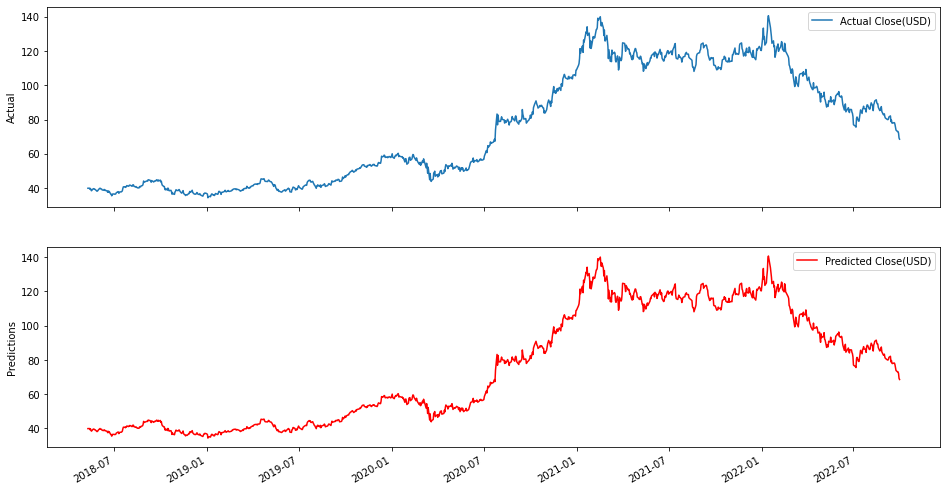

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9))
fig.autofmt_xdate()
ax1.plot(X_test.actual,label="Actual Close(USD)")
ax2.plot(X_test.Predicted,label="Predicted Close(USD)", color='r')
ax1.set_ylabel("Actual")
ax2.set_ylabel("Predictions")
ax1.legend(loc='best')
ax2.legend(loc='best')

In [21]:
X_test['Close']= y_test
results= X_test

###  1 Buy & Hold Trading Strategy
 
* Position trading 
* Buy if we have next days predicted_value greater than todays close value and hold if already bought 
* Sell if we have next days predicted_value lesser than todays close value and dont buy until rule 1

In [22]:
signal = 0
amount = 10000
Amount = []
balance = 0
action = []
portfolio = 0
Portfolio = []
stocks = 0
Stocks = []


for i in range(len(results)-1):
    if results['Predicted'][i+1] > results['actual'][i]:
        if signal == 0:
            action.append('Buy')
            stocks = int(amount / results['actual'][i])
            balance = int(amount % results['actual'][i])
            portfolio = stocks * results['actual'][i]
            signal = 1
            amount = portfolio + balance
            print('Stock:',results['actual'][i] ,'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', 
                  stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
        else:
            action.append('Bought--Holding')
            portfolio = stocks * results['actual'][i]
            amount = portfolio + balance
            print('Stock:',results['actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,
                  'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
            
    elif results['Predicted'][i+1] < results['actual'][i]:
        if signal == 1:
            action.append('Sell')
            portfolio = stocks * results['actual'][i]
            
            signal = 0
            stocks = 0
            amount = balance + portfolio
            portfolio = 0
            balance = 0
            print('Stock:',results['actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,
                  'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
        else:
            action.append('Price-Prediction-Already-Lower')
            print('Stock:',results['actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
            
    print('\n')
    

Stock: 39.91 Action: Buy Portfolio: 9977.5 Stocks: 250 Balance_init: 22 total($) 9999.5


Stock: 39.95 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10009.5


Stock: 39.3 Action: Buy Portfolio: 9982.2 Stocks: 254 Balance_init: 27 total($) 10009.2


Stock: 39.79 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10133.66


Stock: 38.96 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10133.66


Stock: 38.42 Action: Buy Portfolio: 10104.46 Stocks: 263 Balance_init: 29 total($) 10133.46


Stock: 39.47 Action: Bought--Holding Portfolio: 10380.61 Stocks: 263 Balance_init: 29 total($) 10409.61


Stock: 39.64 Action: Bought--Holding Portfolio: 10425.32 Stocks: 263 Balance_init: 29 total($) 10454.32


Stock: 39.65 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10456.95


Stock: 39.27 Action: Buy Portfolio: 10445.82 Stocks: 266 Balance_init: 11 total($) 10456.82


Stock: 39.3 Action: Sell Portfolio: 0 Stocks: 0 Balance

Stock: 41.63 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 18273.4


Stock: 40.96 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 18273.4


Stock: 40.9 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 18273.4


Stock: 39.35 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 18273.4


Stock: 38.94 Action: Buy Portfolio: 18262.86 Stocks: 469 Balance_init: 10 total($) 18272.86


Stock: 39.66 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 18610.54


Stock: 38.75 Action: Buy Portfolio: 18600.0 Stocks: 480 Balance_init: 10 total($) 18610.0


Stock: 40.01 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 19214.8


Stock: 39.57 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 19214.8


Stock: 38.54 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total

Stock: 38.66 Action: Buy Portfolio: 48634.28 Stocks: 1258 Balance_init: 23 total($) 48657.28


Stock: 39.3 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 49462.4


Stock: 38.9 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 49462.4


Stock: 38.07 Action: Buy Portfolio: 49452.93 Stocks: 1299 Balance_init: 9 total($) 49461.93


Stock: 38.2 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 49630.8


Stock: 37.65 Action: Buy Portfolio: 49622.7 Stocks: 1318 Balance_init: 8 total($) 49630.7


Stock: 37.69 Action: Bought--Holding Portfolio: 49675.42 Stocks: 1318 Balance_init: 8 total($) 49683.42


Stock: 38.04 Action: Bought--Holding Portfolio: 50136.72 Stocks: 1318 Balance_init: 8 total($) 50144.72


Stock: 38.35 Action: Bought--Holding Portfolio: 50545.3 Stocks: 1318 Balance_init: 8 total($) 50553.3


Stock: 38.82 Action: Bought--Holding Portfolio: 51164.76 Stocks: 1318 Balance_init: 8 total($) 51172.76


Stock: 39.06 Action: S

Stock: 44.07 Action: Bought--Holding Portfolio: 93604.68 Stocks: 2124 Balance_init: 28 total($) 93632.68


Stock: 44.12 Action: Bought--Holding Portfolio: 93710.88 Stocks: 2124 Balance_init: 28 total($) 93738.88


Stock: 45.01 Action: Bought--Holding Portfolio: 95601.24 Stocks: 2124 Balance_init: 28 total($) 95629.24


Stock: 46.46 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 98709.04


Stock: 45.51 Action: Buy Portfolio: 98665.68 Stocks: 2168 Balance_init: 43 total($) 98708.68


Stock: 46.48 Action: Bought--Holding Portfolio: 100768.64 Stocks: 2168 Balance_init: 43 total($) 100811.64


Stock: 47.19 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 102350.92


Stock: 46.43 Action: Buy Portfolio: 102331.72 Stocks: 2204 Balance_init: 19 total($) 102350.72


Stock: 47.13 Action: Bought--Holding Portfolio: 103874.52 Stocks: 2204 Balance_init: 19 total($) 103893.52


Stock: 47.42 Action: Bought--Holding Portfolio: 104513.68 Stocks: 2204 Balance_init: 19 total($) 1

Stock: 52.15 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 446618.6


Stock: 51.71 Action: Buy Portfolio: 446567.56 Stocks: 8636 Balance_init: 51 total($) 446618.56


Stock: 52.13 Action: Bought--Holding Portfolio: 450194.68 Stocks: 8636 Balance_init: 51 total($) 450245.68


Stock: 52.33 Action: Bought--Holding Portfolio: 451921.88 Stocks: 8636 Balance_init: 51 total($) 451972.88


Stock: 52.91 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 456981.76


Stock: 52.4 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 456981.76


Stock: 51.1 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 456981.76


Stock: 50.92 Action: Buy Portfolio: 456956.08 Stocks: 8974 Balance_init: 25 total($) 456981.08


Stock: 52.1 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 467570.4


Stock: 49.8 Action: Buy Portfolio: 467522.4 Stocks: 9388 Balance_init: 48 total($) 467570.4


Stock: 51.87 Acti

Stock: 78.91 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 1276749.29


Stock: 77.32 Action: Buy Portfolio: 1276707.84 Stocks: 16512 Balance_init: 41 total($) 1276748.84


Stock: 79.4 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 1311093.8


Stock: 78.9 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 1311093.8


Stock: 78.82 Action: Buy Portfolio: 1311091.88 Stocks: 16634 Balance_init: 1 total($) 1311092.88


Stock: 80.5 Action: Bought--Holding Portfolio: 1339037.0 Stocks: 16634 Balance_init: 1 total($) 1339038.0


Stock: 85.85 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 1428029.9


Stock: 83.13 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 1428029.9


Stock: 81.91 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 1428029.9


Stock: 80.23 Action: Buy Portfolio: 1428013.77 Stocks: 17799 Balance_init:

Stock: 118.69 Action: Buy Portfolio: 3223383.02 Stocks: 27158 Balance_init: 115 total($) 3223498.02


Stock: 122.6 Action: Bought--Holding Portfolio: 3329570.8 Stocks: 27158 Balance_init: 115 total($) 3329685.8


Stock: 123.0 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 3340549.0


Stock: 119.23 Action: Buy Portfolio: 3340466.91 Stocks: 28017 Balance_init: 82 total($) 3340548.91


Stock: 126.45 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 3542831.65


Stock: 125.23 Action: Buy Portfolio: 3542756.7 Stocks: 28290 Balance_init: 74 total($) 3542830.7


Stock: 131.3 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 3714551.0


Stock: 130.64 Action: Buy Portfolio: 3714487.12 Stocks: 28433 Balance_init: 63 total($) 3714550.12


Stock: 134.16 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 3814634.28


Stock: 129.14 Action: Buy Portfolio: 3814537.32 Stocks: 29538 Balance_init: 96 total($) 3814633.32


Stock: 130.52 Action: Sell Portfolio:

Stock: 114.63 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 11692775.32


Stock: 111.11 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 11692775.32


Stock: 110.45 Action: Buy Portfolio: 11692678.8 Stocks: 105864 Balance_init: 96 total($) 11692774.8


Stock: 110.52 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 11700185.28


Stock: 108.12 Action: Buy Portfolio: 11700097.68 Stocks: 108214 Balance_init: 87 total($) 11700184.68


Stock: 110.96 Action: Bought--Holding Portfolio: 12007425.44 Stocks: 108214 Balance_init: 87 total($) 12007512.44


Stock: 112.11 Action: Bought--Holding Portfolio: 12131871.54 Stocks: 108214 Balance_init: 87 total($) 12131958.54


Stock: 117.03 Action: Bought--Holding Portfolio: 12664284.42 Stocks: 108214 Balance_init: 87 total($) 12664371.42


Stock: 118.1 Action: Bought--Holding Portfolio: 12780073.4 Stocks: 108214 Balance_init: 87 total($) 12780160.4


Stock: 118.49 

Stock: 116.29 Action: Buy Portfolio: 19357749.69 Stocks: 166461 Balance_init: 95 total($) 19357844.69


Stock: 120.4 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 20041999.4


Stock: 116.57 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 20041999.4


Stock: 116.32 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 20041999.4


Stock: 114.94 Action: Buy Portfolio: 20041972.86 Stocks: 174369 Balance_init: 26 total($) 20041998.86


Stock: 117.44 Action: Bought--Holding Portfolio: 20477895.36 Stocks: 174369 Balance_init: 26 total($) 20477921.36


Stock: 121.3 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 21150985.7


Stock: 120.68 Action: Buy Portfolio: 21150980.2 Stocks: 175265 Balance_init: 5 total($) 21150985.2


Stock: 122.7 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 21505020.5


Stock: 122.06 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_in

Stock: 77.0 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 62491152.64


Stock: 76.11 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 62491152.64


Stock: 75.56 Action: Buy Portfolio: 62491142.4 Stocks: 827040 Balance_init: 10 total($) 62491152.4


Stock: 80.65 Action: Bought--Holding Portfolio: 66700776.0 Stocks: 827040 Balance_init: 10 total($) 66700786.0


Stock: 81.51 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 67412040.4


Stock: 79.11 Action: Buy Portfolio: 67412004.3 Stocks: 852130 Balance_init: 36 total($) 67412040.3


Stock: 79.1 Action: Bought--Holding Portfolio: 67403483.0 Stocks: 852130 Balance_init: 36 total($) 67403519.0


Stock: 81.29 Action: Bought--Holding Portfolio: 69269647.7 Stocks: 852130 Balance_init: 36 total($) 69269683.7


Stock: 83.67 Action: Bought--Holding Portfolio: 71297717.1 Stocks: 852130 Balance_init: 36 total($) 71297753.1


Stock: 85.63 Action: Sell Portfol

In [23]:
results= results.reset_index()

In [24]:
Strategy_Result = pd.DataFrame({'Actual_Close_Price':results.Close[1:],
                                 'Predicted_Close_Price':list(y_pred[1:]),
                                 'Date': results.Date[1:],
                                 'Action':  action,
                                 'Stocks': Stocks,
                                 'Portfolio($)': Portfolio,
                                 'Amount($)':Amount
                                    })

Strategy_Result.head()

,Actual_Close_Price,Predicted_Close_Price,Date,Action,Stocks,Portfolio($),Amount($)
1,39.95,39.961905,2018-05-14,Buy,250,9977.5,10000.0
2,39.30,39.292663,2018-05-15,Sell,0,0.0,10010.0
3,39.79,39.787458,2018-05-16,Buy,254,9982.2,10009.0
4,38.96,38.957214,2018-05-17,Sell,0,0.0,10134.0
5,38.42,38.419161,2018-05-18,Price-Prediction-Already-Lower,0,0.0,10134.0


<AxesSubplot:title={'center':'Total Amount'}>

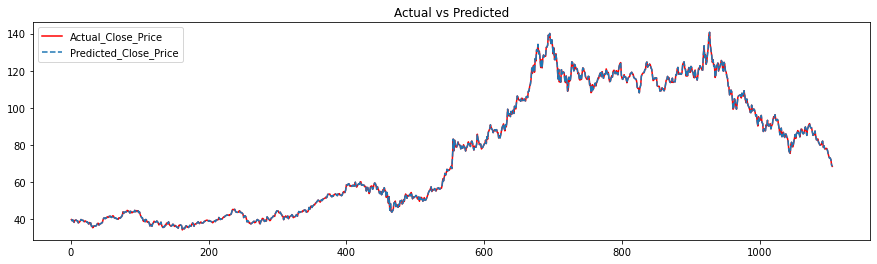

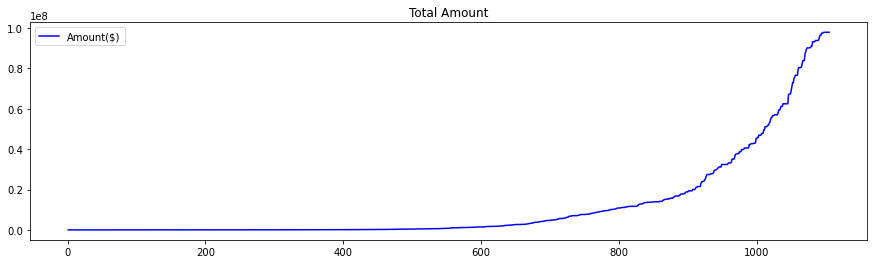

In [25]:
Strategy_Result[['Actual_Close_Price','Predicted_Close_Price']].loc[0:].plot(figsize=(15,4), 
                                                                             style=['-r','--'], 
                                                                             title = 'Actual vs Predicted')


Strategy_Result[['Amount($)']].loc[0:].plot(figsize=(15,4), 
                                            style=['-b'], 
                                            title = 'Total Amount')

In [27]:
# Profit = (Amount[-1])/10000
# print('Initial_Investment : 10000$')
# print('Final Amount:',Amount[-1],'$')      
# print ('Profit_Percent:',Profit*100,'%')

In [31]:
Profit = (Amount[-1] - Amount[-251])/Amount[-251]
print('Initial_Investment : ',Amount[-251])
print('Final Amount:',Amount[-1],'$')      
print ('Profit_Percent latest trading year:',round(Profit*100,2),'%')

Initial_Investment :  13928567.0
Final Amount: 97942925.0 $
Profit_Percent latest trading year: 603.18 %


In [28]:
Strategy_Result['Returns'] = Strategy_Result['Amount($)'].pct_change()

In [29]:
mean_returns = Strategy_Result['Returns'].mean()
sd = Strategy_Result['Returns'].std()
Sharpe_Ratio = np.sqrt(100)*(mean_returns)/sd
Sharpe_Ratio

6.174690696599661

In [30]:
results.index= results['Date']

In [31]:
long_MA = results['actual'].rolling(window=20).mean()
results['Long_Moving_Avg'] = long_MA

In [32]:
short_MA  = results['actual'].rolling(window=5).mean()
results['Short_Moving_Avg'] = short_MA 

In [33]:
long_std= results['actual'].rolling(window=20).std()
results['Long_std'] = long_std

In [34]:
long_upper_band = ((long_MA) + (long_std)*0.75)
results['Long_Upper_Band'] = long_upper_band

In [35]:
long_lower_band = ((long_MA) - (long_std)*0.75)
results['Long_Lower_Band'] = long_lower_band

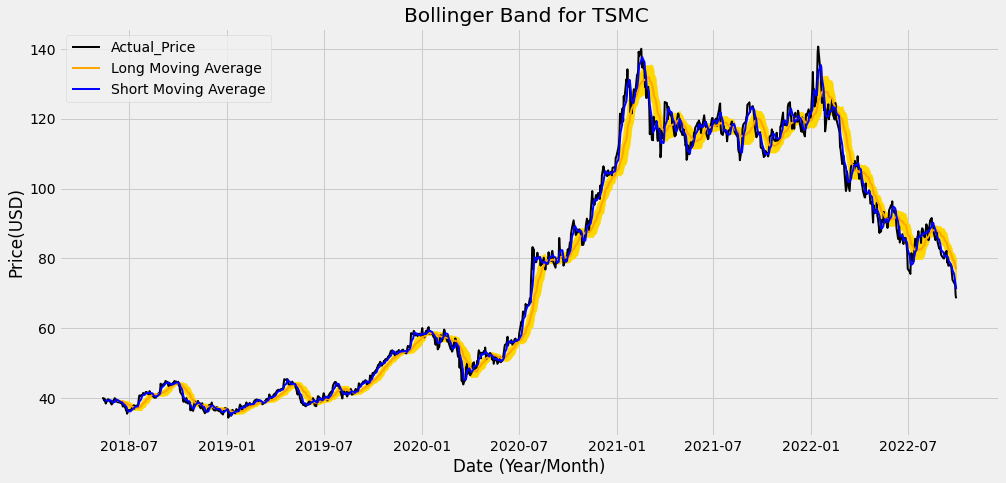

In [32]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
x_axis = results.index
ax.fill_between(x_axis, results['Long_Upper_Band'], results['Long_Lower_Band'], color='gold')
ax.plot(x_axis, results['actual'], color='black', lw=2, label = 'Actual_Price')
ax.plot(x_axis, results['Long_Moving_Avg'], color='orange', lw=2, label = 'Long Moving Average')
ax.plot(x_axis, results['Short_Moving_Avg'], color='blue', lw=2, label = 'Short Moving Average')

ax.set_title('Bollinger Band for TSMC ')
ax.set_xlabel('Date (Year/Month)')
ax.set_ylabel('Price(USD)')
ax.legend()
plt.show()